<h3><center>Introduction</center></h3>
<div style="font-family:verdana; word-spacing:1.7px;">
In this kernel we will be working with data from Google Cloud & NCAA® ML Competition 2019-Men's Challenge. We'll try to predict winners of NCAA based on previous tournaments! We have a lot of data, so let's start with EDA and then build a baseline model.

</div>

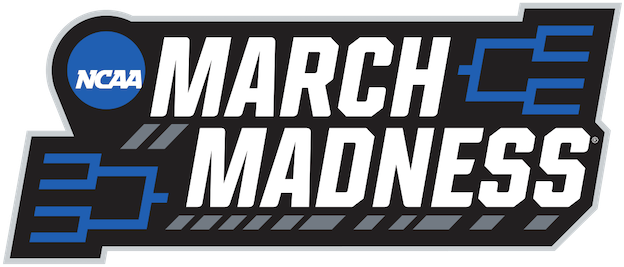

<h2><center>1. Importing Libraries</center></h2>

In [92]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
from scipy import stats

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


import matplotlib.pylab as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal

import gc

import eli5

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, \
                                        RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

import lightgbm as lgb
import xgboost as xgb

0it [00:00, ?it/s]

In [2]:
PATH_MEN = '/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/'

<h2><center>2. Exploring Data</center></h2>

<h3>2.1. Teams Data</h3>

<h3>Newbies</h3>

In [3]:
MTeams = pd.read_csv(PATH_MEN + '/MDataFiles_Stage1/MTeams.csv')
MTeams.sort_values(by='FirstD1Season', ascending=False).head(10)

,TeamID,TeamName,FirstD1Season,LastD1Season
366,1467,Merrimack,2020,2020
365,1466,North Alabama,2019,2020
364,1465,Cal Baptist,2019,2020
112,1213,Grand Canyon,2014,2020
161,1262,MA Lowell,2014,2020
129,1230,Incarnate Word,2014,2020
0,1101,Abilene Chr,2014,2020
196,1297,N Kentucky,2013,2020
202,1303,NE Omaha,2012,2020
276,1377,South Dakota,2009,2020


<h3>Oldies</h3>

In [4]:
MTeams.sort_values(by='FirstD1Season').head(10)

,TeamID,TeamName,FirstD1Season,LastD1Season
183,1284,Monmouth NJ,1985,2020
230,1331,Oral Roberts,1985,2020
229,1330,Old Dominion,1985,2020
228,1329,Oklahoma St,1985,2020
227,1328,Oklahoma,1985,2020
226,1327,Okla City,1985,1985
225,1326,Ohio St,1985,2020
224,1325,Ohio,1985,2020
222,1323,Notre Dame,1985,2020
221,1322,Northwestern LA,1985,2020


<h3>2.2. Seasons Data</h3>

In [5]:
MSeasons = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MSeasons.csv')

MSeasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


<h3>2.3. Seed Data</h3>

In [6]:
MNCAATourneySeeds = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
MNCAATourneySeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


<h3>2.4. Regular Season Results</h3>

In [7]:
MRegularSeasonCompactResults = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
MRegularSeasonCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


<h3>Winning & losing Teams</h3>

In [8]:
# Lets Add the winning and losing team names to the results
MRegularSeasonCompactResults = \
    MRegularSeasonCompactResults \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})

MRegularSeasonCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName
0,1985,20,1228,81,1328,64,N,0,Illinois,Oklahoma
1,1985,33,1228,73,1328,70,H,0,Illinois,Oklahoma
2,1990,82,1112,78,1328,74,H,0,Arizona,Oklahoma
3,2011,34,1112,83,1328,60,H,0,Arizona,Oklahoma
4,1985,118,1242,82,1328,76,H,0,Kansas,Oklahoma


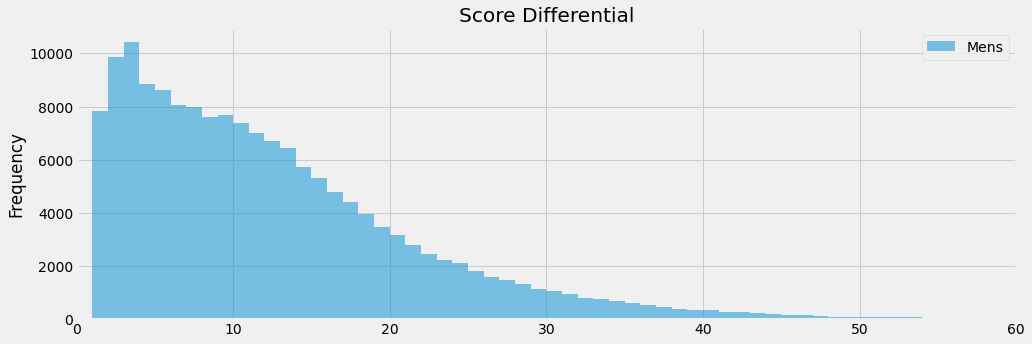

In [9]:
MRegularSeasonCompactResults['Score_Diff'] = MRegularSeasonCompactResults['WScore'] - MRegularSeasonCompactResults['LScore']

plt.style.use('fivethirtyeight')
MRegularSeasonCompactResults['Score_Diff'] \
    .plot(kind='hist',
          bins=90,
          figsize=(15, 5),
          label='Mens',
          alpha=0.5)
plt.title('Score Differential')
plt.xlim(0,60)
plt.legend()
plt.show()

In [10]:
MRegularSeasonCompactResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName,Score_Diff
0,1985,20,1228,81,1328,64,N,0,Illinois,Oklahoma,17
1,1985,33,1228,73,1328,70,H,0,Illinois,Oklahoma,3
2,1990,82,1112,78,1328,74,H,0,Arizona,Oklahoma,4
3,2011,34,1112,83,1328,60,H,0,Arizona,Oklahoma,23
4,1985,118,1242,82,1328,76,H,0,Kansas,Oklahoma,6
...,...,...,...,...,...,...,...,...,...,...,...
161547,2019,20,1188,80,1230,68,H,0,SIUE,Incarnate Word,12
161548,2018,103,1101,80,1230,69,H,0,Abilene Chr,Incarnate Word,11
161549,2018,124,1101,69,1230,59,A,0,Abilene Chr,Incarnate Word,10
161550,2019,103,1101,68,1230,48,A,0,Abilene Chr,Incarnate Word,20


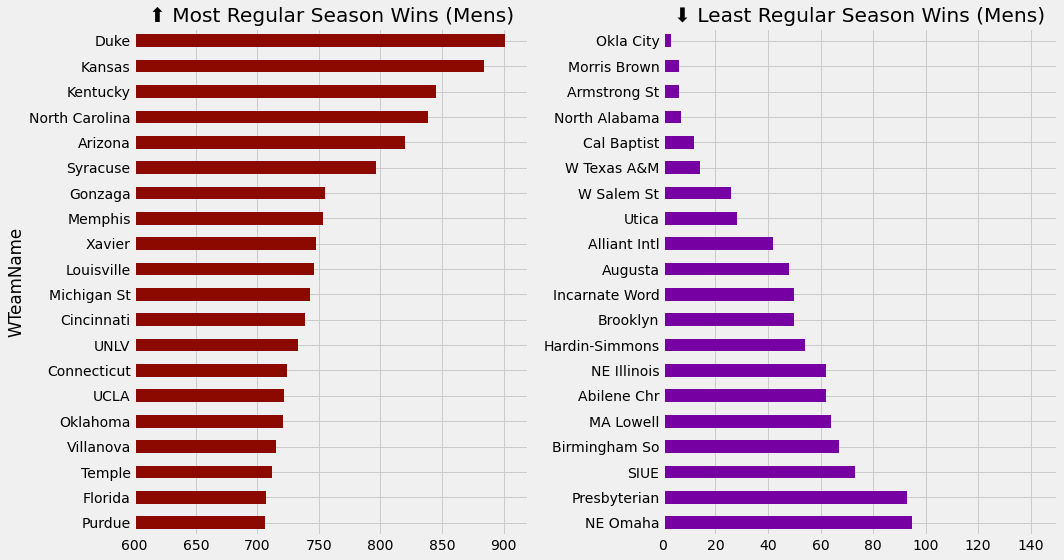

In [11]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MRegularSeasonCompactResults['counter'] = 1
MRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values() \
    .tail(20) \
    .plot(kind='barh',
          title='⬆️ Most Regular Season Wins (Mens)',
          figsize=(15, 8),
          xlim=(600, 920),
          color=mypal[2],
         ax=axs[0])
MRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values(ascending=False) \
    .tail(20) \
    .plot(kind='barh',
          title='⬇️ Least Regular Season Wins (Mens)',
          figsize=(15, 8),
          xlim=(0, 150),
          color=mypal[3],
          ax=axs[1])
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

<h3>2.5. Event Data</h3>

Each event is assigned to either a team or a single one of the team's players. Thus if a basket is made by one player and an assist is credited to a second player, that would show up as two separate records. The players are listed by PlayerID within the xPlayers.csv file.

In [12]:
mens_events = []
for year in [2015, 2016, 2017, 2018, 2019]:
    mens_events.append(pd.read_csv(f'{PATH_MEN}MEvents{year}.csv'))
MEvents = pd.concat(mens_events)
print(MEvents.shape)
MEvents.head()

(13149684, 17)


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,1,2015,11,1103,1420,74,57,0,0,19,1103,100,miss3,unk,0,0,0
1,2,2015,11,1103,1420,74,57,0,0,19,1420,11784,reb,def,0,0,0
2,3,2015,11,1103,1420,74,57,0,0,27,1420,11789,made2,dunk,0,0,0
3,4,2015,11,1103,1420,74,57,0,0,27,1420,11803,assist,NaN,0,0,0
4,5,2015,11,1103,1420,74,57,0,0,59,1103,87,made2,jump,0,0,0


In [13]:
del mens_events
gc.collect()

8209

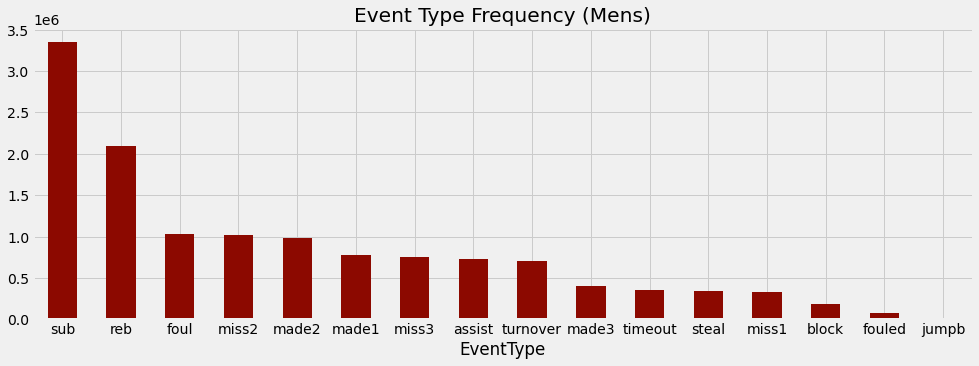

In [14]:
plt.style.use('fivethirtyeight')
MEvents['counter'] = 1
MEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='bar',
          figsize=(15, 5),
         color=mypal[2],
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()

<h3>Area Event</h3>

<div style="font-family:verdana; word-spacing:1.7px;">
We are told that the Area feature describes the 13 "areas" of the court, as follows: 1=under basket; 2=in the paint; 3=inside right wing; 4=inside right; 5=inside center; 6=inside left; 7=inside left wing; 8=outside right wing; 9=outside right; 10=outside center; 11=outside left; 12=outside left wing; 13=backcourt.
    </div>

In [15]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

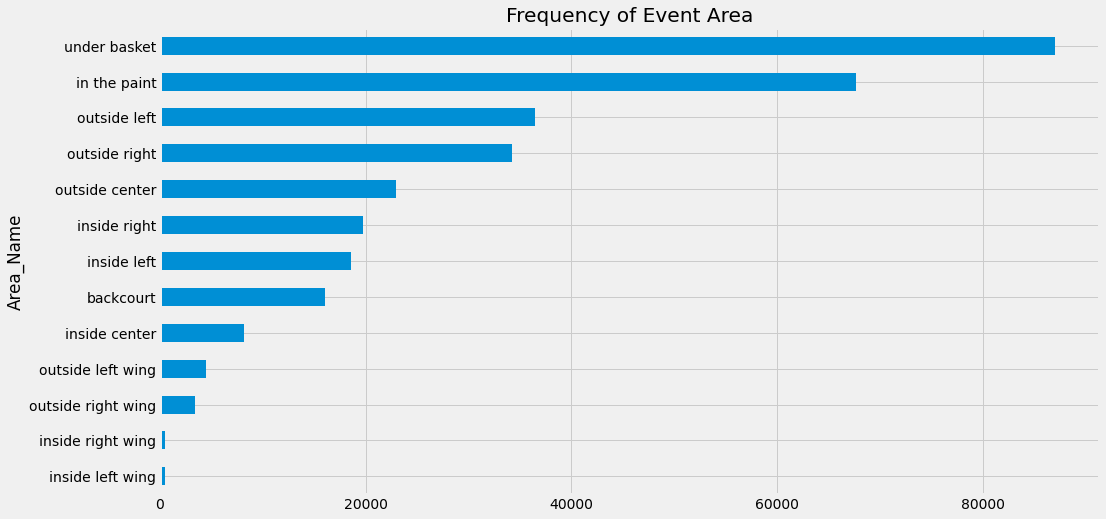

In [16]:
MEvents.groupby('Area_Name')['counter'].sum() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 8),
          title='Frequency of Event Area')
plt.show()

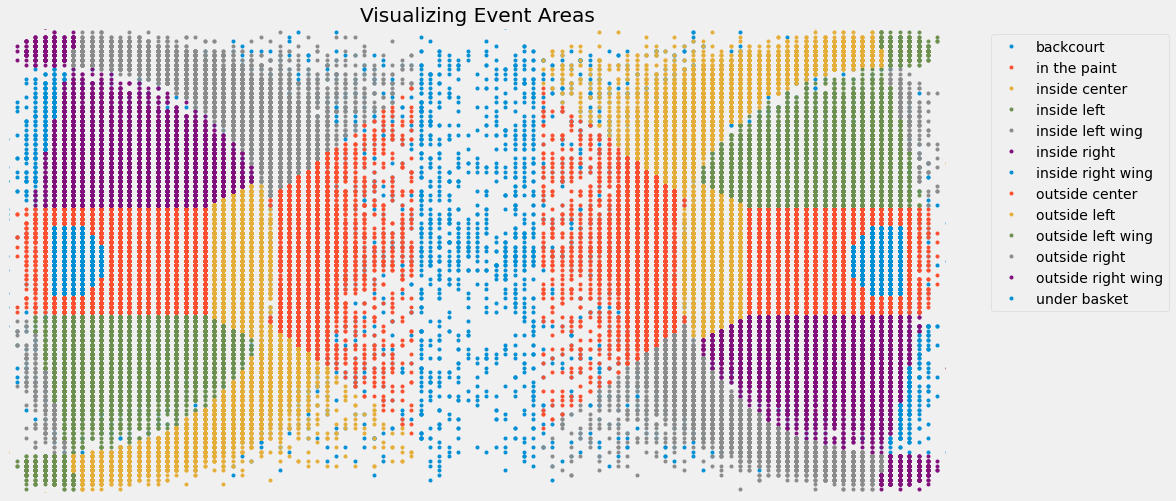

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, d in MEvents.loc[~MEvents['Area_Name'].isna()].groupby('Area_Name'):
    d.plot(x='X', y='Y', style='.', label=i, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

<h3>2.6. PlayerIDs</h3>

In [18]:
MPlayers = pd.read_csv(PATH_MEN + 'MPlayers.csv', error_bad_lines=False)

MPlayers.head()

,PlayerID,LastName,FirstName,TeamID
0,1,Albright,Christian,1101
1,2,Cameron,Tobias,1101
2,3,Cobb,Chase,1101
3,4,Cooke,Austin,1101
4,5,Crnic,Jovan,1101


In [19]:
del MEvents
del MNCAATourneySeeds
del MPlayers
del MRegularSeasonCompactResults
del MSeasons
del MTeams
gc.collect()

15571

<h3><center>3. Preparing Training & Validation Data</center></h3>

In [20]:
tourney_result = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_result = tourney_result[tourney_result['Season'] < 2015]

tourney_seed = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_seed = tourney_seed[tourney_seed['Season'] < 2015]

tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)

tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)

tourney_result = tourney_result.drop('TeamID', axis=1)


tourney_result['WSeed'] = tourney_result['WSeed'].apply(lambda x: int(x[1:3]))
tourney_result['LSeed'] = tourney_result['LSeed'].apply(lambda x: int(x[1:3]))

In [21]:
season_result = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
season_result = season_result[season_result['Season'] < 2015]

season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]

season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)

season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)

season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()



tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)



tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)

tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']

In [22]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

Training Data

In [23]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
train_df = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
train_df.head()

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1


In [44]:
train_df['result'].value_counts()

1    1916
0    1916
Name: result, dtype: int64

In [24]:
season_result.head()

,Season,TeamID,Score
0,1985,1228,81
1,1985,1106,77
2,1985,1112,63
3,1985,1165,70
4,1985,1192,86


In [25]:
tourney_result.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,WScoreT,LScoreT
0,1985,1116,1234,9,8,2156,2092
1,1985,1120,1345,11,6,2040,1728
2,1985,1207,1250,1,16,2045,1907
3,1985,1229,1425,9,8,1933,1915
4,1985,1242,1325,3,14,2281,1824


Testing Data

In [26]:
test_df = pd.read_csv(PATH_MEN+'MSampleSubmissionStage1_2020.csv')
sub = test_df.copy()

test_df.head()

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


In [27]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))

In [28]:
tourney_seed = pd.read_csv(PATH_MEN + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_seed = tourney_seed[tourney_seed['Season'] > 2014]

In [29]:
season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
season_result = season_result[season_result['Season'] > 2014]
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()

In [30]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)

In [31]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: int(x[1:3]))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: int(x[1:3]))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df.head()

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff
0,14,2,2096,2599,12,-503
1,14,5,2096,2653,9,-557
2,14,3,2096,2212,11,-116
3,14,15,2096,2287,-1,-191
4,14,11,2096,2166,3,-70


In [32]:
X = train_df.drop('result', axis=1)
y = train_df.result

<h3><center>4. Model Test & Baseline result</center></h3>

In [78]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

In [79]:
model = DummyClassifier(strategy='uniform')

scores = evaluate_model(X, y, model)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.506 (0.024)


<h3><center>5. Evaluate Machine Learning Algorithms</center></h3>

In [80]:
def get_models():
    models, names = list(), list()
    # LR 
    models.append(LogisticRegression(solver='lbfgs')) 
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis()) 
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

In [81]:
models, names = get_models()

results = list()


for i in range(len(models)):
    
    pipeline = Pipeline(steps=[('scale',MinMaxScaler()),('m',models[i])])
    
    scores = evaluate_model(X, y, pipeline)
    
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores))) 

>LR 0.710 (0.024)
>LDA 0.710 (0.024)
>NB 0.709 (0.023)
>SVM 0.704 (0.025)


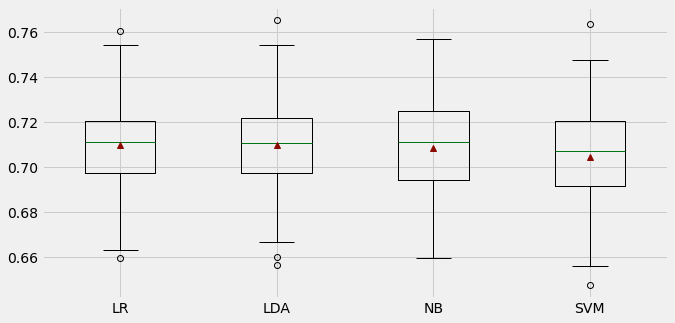

In [82]:
plt.figure(figsize=(10,5))
_ = plt.boxplot(results, labels=names, showmeans=True) 
_ = plt.show()

In [83]:
# LGB
lgb_num_leaves_max = 255
lgb_in_leaf = 50
lgb_lr = 0.0001
lgb_bagging = 7

# XGB
xgb_max_depth = 20
xgb_min_child_weight = 75
xgb_lr = 0.0005
xgb_num_boost_round_max = 4000
# without early_stopping_rounds

# Set weight of models
w_lgb = 0.6
w_xgb = 0.3
w_logreg = 1 - w_lgb - w_xgb

<h3>6. LGB</h3>

In [84]:
params_lgb = {'num_leaves': lgb_num_leaves_max,
              'min_data_in_leaf': lgb_in_leaf,
              'objective': 'binary',
              'max_depth': -1,
              'learning_rate': lgb_lr,
              "boosting_type": "gbdt",
              "bagging_seed": lgb_bagging,
              "metric": 'logloss',
              "verbosity": -1,
              'random_state': 42,
             }

In [96]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)
#folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

columns = X.columns
splits = folds.split(X, y)
y_preds_lgb = np.zeros(test_df.shape[0])
y_train_lgb = np.zeros(X.shape[0])
y_oof = np.zeros(X.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    
    y_train_lgb += clf.predict(X) / NFOLDS
    y_preds_lgb += clf.predict(test_df) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


In [88]:
def plot_cm(y_true, y_pred, title, figsize=(7,6)):
    y_pred = y_pred.round().astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

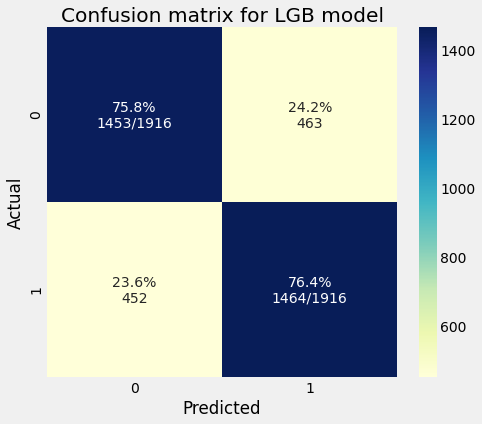

In [95]:
plot_cm(y, y_train_lgb, 'Confusion matrix for LGB model')

<h3>7. XGB</h3>

In [97]:
params_xgb = {'max_depth': xgb_max_depth,
              'objective': 'binary:logistic',
              'min_child_weight': xgb_min_child_weight,
              'learning_rate': xgb_lr,
              'eta'      : 0.3,
              'subsample': 0.8,
              'lambda '  : 4,
              'eval_metric': 'logloss',
              'colsample_bytree ': 0.9,
              'colsample_bylevel': 1
              }

In [98]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)

y_preds_xgb = np.zeros(test_df.shape[0])
y_train_xgb = np.zeros(X.shape[0])
y_oof_xgb = np.zeros(X.shape[0])

train_df_set = xgb.DMatrix(X)
test_set = xgb.DMatrix(test_df)
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train, y_train)
    val_set = xgb.DMatrix(X_valid, y_valid)
    
    clf = xgb.train(params_xgb, train_set, num_boost_round=xgb_num_boost_round_max, evals=[(train_set, 'train'), (val_set, 'val')], verbose_eval=100)
    
    y_train_xgb += clf.predict(train_df_set) / NFOLDS
    y_preds_xgb += clf.predict(test_set) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
[09:14:56] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.69302	val-logloss:0.69307
[100]	train-logloss:0.68081	val-logloss:0.68590
[200]	train-logloss:0.66971	val-logloss:0.67958
[300]	train-logloss:0.65954	val-logloss:0.67396
[400]	train-logloss:0.65024	val-logloss:0.66893
[500]	train-logloss:0.64172	val-logloss:0.66451
[600]	train-logloss:0.63388	val-logloss:0.66055
[700]	train-logloss:0.62668	val-logloss:0.65705
[800]	train-logloss:0.62009	val-logloss:0.65402
[900]	train-logloss:0.61401	val-logloss:0.65133
[1000]	train-logloss:0.60838	val-logloss:0.64896
[1100]	train-logloss:0.60317	val-logloss:0.64687
[1200]	train-logloss:0.59839	val-logloss:0.64509
[1300]	train-logloss:

[1700]	train-logloss:0.58233	val-logloss:0.62728
[1800]	train-logloss:0.57942	val-logloss:0.62585
[1900]	train-logloss:0.57671	val-logloss:0.62454
[2000]	train-logloss:0.57420	val-logloss:0.62337
[2100]	train-logloss:0.57185	val-logloss:0.62235
[2200]	train-logloss:0.56968	val-logloss:0.62147
[2300]	train-logloss:0.56765	val-logloss:0.62070
[2400]	train-logloss:0.56579	val-logloss:0.62008
[2500]	train-logloss:0.56405	val-logloss:0.61952
[2600]	train-logloss:0.56242	val-logloss:0.61906
[2700]	train-logloss:0.56091	val-logloss:0.61867
[2800]	train-logloss:0.55950	val-logloss:0.61835
[2900]	train-logloss:0.55819	val-logloss:0.61810
[3000]	train-logloss:0.55697	val-logloss:0.61786
[3100]	train-logloss:0.55583	val-logloss:0.61761
[3200]	train-logloss:0.55478	val-logloss:0.61754
[3300]	train-logloss:0.55379	val-logloss:0.61750
[3400]	train-logloss:0.55287	val-logloss:0.61751
[3500]	train-logloss:0.55202	val-logloss:0.61751
[3600]	train-logloss:0.55122	val-logloss:0.61759
[3700]	train-logloss

Fold: 8
[09:16:04] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.69302	val-logloss:0.69307
[100]	train-logloss:0.68090	val-logloss:0.68609
[200]	train-logloss:0.66981	val-logloss:0.68002
[300]	train-logloss:0.65970	val-logloss:0.67465
[400]	train-logloss:0.65041	val-logloss:0.66983
[500]	train-logloss:0.64193	val-logloss:0.66550
[600]	train-logloss:0.63412	val-logloss:0.66166
[700]	train-logloss:0.62692	val-logloss:0.65825
[800]	train-logloss:0.62031	val-logloss:0.65526
[900]	train-logloss:0.61422	val-logloss:0.65256
[1000]	train-logloss:0.60859	val-logloss:0.65026
[1100]	train-logloss:0.60345	val-logloss:0.64830
[1200]	train-logloss:0.59868	val-logloss:0.64658
[1300]	train-logloss:

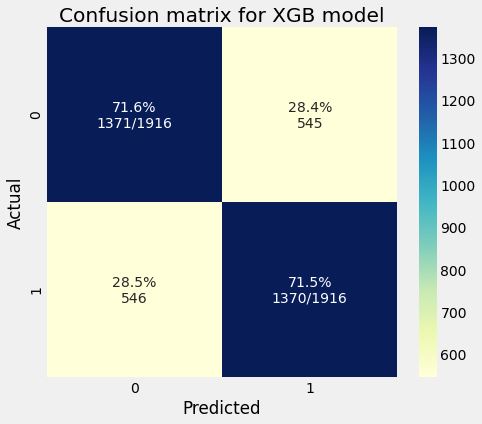

In [99]:
plot_cm(y, y_train_xgb, 'Confusion matrix for XGB model')

<h3>8. Log Reg </h3>

In [114]:
scale = MinMaxScaler()
X_scaled = scale.fit_transform(X)
X_test_scaled = scale.transform(test_df)

model = LogisticRegression(solver='liblinear')

model.fit(X_scaled, y)

y_logreg_train = model.predict(X_scaled)
y_logreg_pred = model.predict(X_test_scaled)

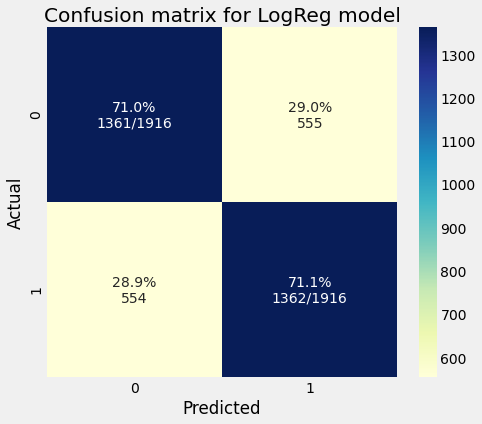

In [115]:
plot_cm(y, y_logreg_train, 'Confusion matrix for LogReg model')

<h3><center>9. Merging Solutions</center></h3>

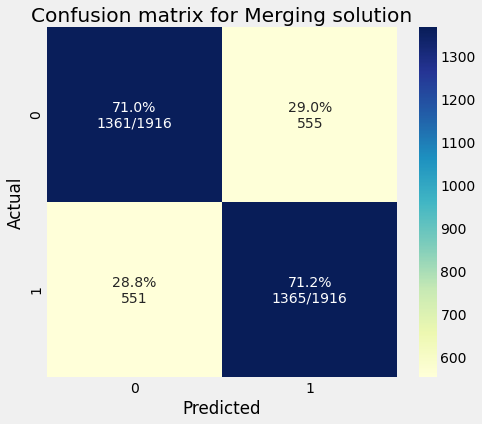

In [117]:
y_train_preds = 0.8*y_train_lgb + 0.1*y_train_xgb + 0.1*y_logreg_train

plot_cm(y, y_train_preds, 'Confusion matrix for Merging solution')
